In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline


Bad key text.latex.preview in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\

In [2]:
import numpy as np
import pandas as pd
from quetzal.model import stepmodel
from quetzal.io import excel

# Modelling steps 1 and 2.
## Saves transport demand between zones
## Needs zones

In [3]:
input_path = '../input/transport_demand/'
output_path = '../output/'
model_path = '../model/' + scenario + '/'

In [4]:
# Load parameters for settings
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [5]:
sm = stepmodel.read_json(model_path + 'de_zones')

### Emission and attraction with quetzal


Steps: Generation and distribution --> Transport demand in volumes<br>
Transport volumes can be generated by using the function<br>

step_distribution(impedance_matrix=None, **od_volume_from_zones_kwargs)<br>
    :param impedance_matrix: an OD unstaked friction dataframe<br>
        used to compute the distribution.<br>
    :param od_volume_from_zones_kwargs: if the friction matrix is not<br>
        provided, it will be automatically computed using a gravity<br>
        distribution which uses the following parameters:<br>
        param power: (int) the gravity exponent<br>
        param intrazonal: (bool) set the intrazonal distance to 0 if False,<br>
            compute a characteristic distance otherwise.<br>
            
Or create the volumes from input data<br>

### Load transport demand data from VP2030

The German federal government's transport study "[Bundesverkehrswegeplan 2030](https://www.bmvi.de/SharedDocs/DE/Artikel/G/BVWP/bundesverkehrswegeplan-2030-inhalte-herunterladen.html)" uses origin destination matrices on NUTS3-level resolution and makes them accessible under copyright restrictions for the base year and the year of prognosis. These matrices cannot be published in their original form.

In [6]:
vp2010 = pd.read_csv(input_path + 'PVMatrix_BVWP15_A2010.csv', sep=';', encoding='latin-1')
vp2030 = pd.read_csv(input_path + 'PVMatrix_BVWP15_P2030.csv', sep=';', encoding='latin-1')

In [7]:
for df in [vp2010, vp2030]:
    df.rename(columns={'# Quelle': 'origin', 'Ziel': 'destination'}, inplace=True)

In [8]:
assert len(vp2010[vp2010.isna().any(axis=1)]) == 0

In [9]:
def get_year(vp2010_i, vp2030_i, year=2017):
    return vp2010_i + (vp2030_i - vp2010_i) * ((year-2010) / 20)

In [10]:
# Calculate a OD table for the year given
vp = get_year(vp2010.set_index(['origin', 'destination']),
              vp2030.set_index(['origin', 'destination']),
              int(params['general']['year']))

In [11]:
print(vp.shape)
print(len(vp[vp.isna().any(axis=1)]))
vp.dropna(how='all', inplace=True)

(313990, 36)
594


In [12]:
vp = vp[list(vp.columns)].astype(int)
#vp.head()

### Create the volumes table

In [13]:
# Sum up trips by purpose
# Walking trips don't matter for the aggregated model
for suffix in ['Fz1', 'Fz2', 'Fz3', 'Fz4', 'Fz5', 'Fz6']:
    vp[suffix] = vp[[col for col in list(vp.columns)
                     if col[-3:] == suffix and not col[:3] in ['Fuß']]
                   ].sum(axis=1)

In [14]:
# Merge purpose 5 and 6 due to calibration data limitations
vp['Fz6'] = vp['Fz5'] + vp['Fz6']

In [15]:
# Replace LAU IDs with NUTS IDs in origin and destination
if not 'lau_id' in sm.zones.columns:
    sm.zones['lau_id'] = sm.zones['ARS'].apply(lambda l: l[0]).apply(str).str[:-4]
nuts_lau_dict = sm.zones.set_index('lau_id')['NUTS_ID'].to_dict()
vp.reset_index(level=['origin', 'destination'], inplace=True)

In [16]:
# Zones that appear in the VP (within Germany) but not in the model
sorted([i for i in set(list(vp['origin'])+list(vp['destination'])) -
        set([int(k) for k in nuts_lau_dict.keys()]) if i<=16077])

[2109,
 3152,
 3156,
 3509,
 4109,
 5209,
 5219,
 5229,
 5239,
 5249,
 5269,
 6119,
 7009,
 8019,
 8029,
 8049,
 9019,
 9049,
 10109,
 11019,
 13001,
 13002,
 13005,
 13006,
 13051,
 13052,
 13053,
 13054,
 13055,
 13056,
 13057,
 13058,
 13059,
 13060,
 13061,
 13062,
 14109,
 14119,
 16056]

In [17]:
# Most of the above numbers are airports in the VP, however
# NUTS3-level zones changed after the VP2030
# Thus the VP table needs to be updated manually
update_dict = {3156: 3159, 3152: 3159, # Göttingen
               13001: 13075, 13002: 13071, 13005: 13073, 13006: 13074,
               13051: 13072, 13052: 13071, 13053: 13072, 13054: 13076, 13055: 13071, 13056: 13071,
               13057: 13073, 13058: 13074, 13059: 13075, 13060: 13076, 13061: 13073, 13062: 13075}
if len(sm.zones) > 401:
    update_dict[16056] = 16063

In [18]:
# What is the sum of all trips? For Validation
cols = [c for c in vp.columns if c not in ['origin', 'destination']]
orig_sum = vp[cols].sum().sum()
orig_sum

181145945371

In [19]:
# Update LAU codes
vp['origin'] = vp['origin'].replace(update_dict)
vp['destination'] = vp['destination'].replace(update_dict)

In [20]:
# Zones ending on 9 are international airports or ports
sorted([i for i in set(list(vp['origin'])+list(vp['destination'])) -
        set([int(k) for k in nuts_lau_dict.keys()]) if i<=16077])

[2109,
 3509,
 4109,
 5209,
 5219,
 5229,
 5239,
 5249,
 5269,
 6119,
 7009,
 8019,
 8029,
 8049,
 9019,
 9049,
 10109,
 11019,
 14109,
 14119]

In [21]:
# Replace LAU with NUTS
vp['origin'] = vp['origin'].astype(str).map(nuts_lau_dict)
vp['destination'] = vp['destination'].astype(str).map(nuts_lau_dict)

In [22]:
# Restrict to cells in the model
vp = vp[~vp.isna().any(axis=1)]

In [23]:
vp.shape

(169744, 44)

In [24]:
# What is the sum of all trips after ditching outer-German trips?
vp_sum = vp[cols].sum().sum()
vp_sum / orig_sum

0.9864959391777166

In [25]:
# Aggregate OD pairs
vp = vp.groupby(['origin', 'destination']).sum().reset_index()
vp[cols].sum().sum() / orig_sum

0.9864959391777166

In [26]:
# Share of trips between NUTS3 zones
vp.loc[vp['origin']!=vp['destination'], cols].sum().sum() / vp_sum

0.17589830980569904

In [27]:
sm.volumes = vp[['origin', 'destination', 'Fz1', 'Fz2', 'Fz3', 'Fz4', 'Fz6']
               ].copy().set_index(['origin', 'destination'], drop=True)

### Add car ownership segments

Comment or uncomment the following cells to add or remove car ownership segments

In [28]:
# Car availabilities from MiD2017 data by VP2030 purpose
av = dict(zip(list(sm.volumes.columns),
              [0.970375, 0.965208, 0.968122, 0.965517, 0.95646]))

In [29]:
# Split purpose cells into car ownership classes
if len(params['general']['demand_segments'].split(';')) > 6:
    cols = list(sm.volumes.columns)
    for col in cols:
        for car in [0,1]:
            sm.volumes[col+'_'+str(car)] = sm.volumes[col] * abs(((1-car)*1 - av[col]))
    sm.volumes.drop(cols, axis=1, inplace=True)

In [30]:
sm.volumes.reset_index(inplace=True)

### Split into model zones

Use population shares of the NUTS3 sub-zone, if the zoning system is finer.

In [31]:
# Share of within-NUTS3-level traffic
segments = [c for c in sm.volumes.columns if c not in ['origin', 'destination']]
mask = sm.volumes['origin']==sm.volumes['destination']
sm.volumes.loc[mask, segments].sum().sum() / vp_sum

0.34670057839436913

In [33]:
# Correct the share of inner-NUTS3 traffic
# so that it corresponds to model zone sizes
# Calculated from difference of model's and TREMOD's
# average yearly mileage of cars: 40% too much in
# the inter-zonal part of the model results
if len(sm.zones) > 401:
    sm.volumes.loc[mask, segments] = sm.volumes.loc[mask, segments] * 0.09 #((1-0.4) * 0.872)
    # Share of within-NUTS3-level traffic
    sm.volumes.loc[mask, segments].sum().sum() / vp_sum

0.03120305205549322

In [34]:
if len(sm.zones) > 401:
    vol = sm.zones[['FID', 'pop_share']].merge(sm.zones[['FID', 'pop_share']], how='cross'
                                              ).rename(columns={'FID_x':'origin', 'FID_y':'destination'})
    island_dict = sm.zones.loc[['outer_1', 'outer_2'], 'NUTS_ID'].to_dict()
    vol['o'] = vol['origin'].replace(island_dict).str[:5]
    vol['d'] = vol['destination'].replace(island_dict).str[:5]
    for seg in segments:
        segment = sm.volumes.set_index(['origin', 'destination'])[seg].to_dict()
        vol[seg] = vol['pop_share_x'] * vol['pop_share_y'] * [
            segment[tuple(od)] 
            if tuple(od) in segment.keys() else np.nan
            for od in vol[['o', 'd']].values]
    # Number of trips compared to before
    vol[segments].sum() / sm.volumes[segments].sum()

In [36]:
# Share of trips between model zones
if len(sm.zones) > 401:
    vol.loc[vol['origin']!=vol['destination'], segments].sum().sum() / vp_sum

0.10518114362823958

In [37]:
# Share of trips between NUTS3 zones
if len(sm.zones) > 401:
    vol.loc[vol['o']!=vol['d'], segments].sum().sum() / vp_sum

0.08786056613671579

In [38]:
# Drop rows that did not exist in the VP volumes
# as there is no travel demand on these OD pairs
if len(sm.zones) > 401:
    vol = vol.loc[~vol[segments].isna().all(axis=1)]
    assert vol.isna().any(axis=1).max() == 0
    # Also drop OD pairs with 0 travel demand
    vol = vol.loc[vol.sum(axis=1)>0]
    # Assign as volumes table
    sm.volumes = vol[list(sm.volumes.columns)]

## Sparsify the OD set

Reduce the number of OD pairs to a sample while keeping the number of trips constant.

In [ ]:
# Only sample, if the parameter is specified
sample_size = params['general']['od_sparse_sample']
if sample_size > 0:
    # Set a stable seed, generating the same OD set in every scenario run
    np.random.seed(42)
    for seg in segments:
        # Choice probabilities of OD pairs weighted by trip volumes
        od_probabilities = sm.volumes[seg] / sm.volumes[seg].sum()
        sample = np.random.choice(a=sm.volumes.index,
                                  size=sample_size,
                                  p=od_probabilities)
        # Reduce the volumes matrix
        expansion = sm.volumes[seg].sum() / sample_size
        sm.volumes[seg] = pd.Series(sample).value_counts() * expansion

In [ ]:
# Check the sum
sm.volumes.loc[sm.volumes.notna().all(axis=1), segments].sum().sum() / 365 / 1e6

In [ ]:
sm.volumes = sm.volumes.loc[sm.volumes.notna().all(axis=1)]

## Save model

In [40]:
sm.volumes.shape

(4946112, 12)

In [41]:
sm.volumes.columns

Index(['origin', 'destination', 'Fz1_0', 'Fz1_1', 'Fz2_0', 'Fz2_1', 'Fz3_0',
       'Fz3_1', 'Fz4_0', 'Fz4_1', 'Fz6_0', 'Fz6_1'],
      dtype='object')

In [42]:
sm.volumes = sm.volumes.loc[sm.volumes.sum(axis=1)>0]
sm.volumes.shape

In [43]:
# Saving volumes
sm.to_zippedpickles(model_path + 'de_volumes_exo', only_attributes=['volumes'])

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 34/34 [00:31<00:00,  1.08it/s]


## Create validation table

Generate a normalised matrix for the year 2017 in order to validate model results against each other. It is needed for the calibration step.

In [26]:
# Merge purpose 5 and 6
for prefix in ['Bahn', 'MIV', 'Luft', 'OESPV', 'Rad', 'Fuß']:
    vp[prefix + '_Fz6'] = vp[prefix + '_Fz5'] + vp[prefix + '_Fz6']
vp = vp[[col for col in list(vp.columns) if col[-1]!='5']]

In [27]:
# Merge bicycle and foot
for p in [1,2,3,4,6]:
    vp['non_motor_Fz' + str(p)] = vp['Rad_Fz' + str(p)] + vp['Fuß_Fz' + str(p)]
vp = vp[[col for col in list(vp.columns) if not col[:3] in ['Rad', 'Fuß']]]

In [28]:
# Prepare columns
vp.set_index(['origin', 'destination'], drop=True, inplace=True)
vp = vp[[col for col in vp.columns if col[:2]!='Fz']]
vp.columns

Index(['Bahn_Fz1', 'Bahn_Fz2', 'Bahn_Fz3', 'Bahn_Fz4', 'Bahn_Fz6', 'MIV_Fz1',
       'MIV_Fz2', 'MIV_Fz3', 'MIV_Fz4', 'MIV_Fz6', 'Luft_Fz1', 'Luft_Fz2',
       'Luft_Fz3', 'Luft_Fz4', 'Luft_Fz6', 'OESPV_Fz1', 'OESPV_Fz2',
       'OESPV_Fz3', 'OESPV_Fz4', 'OESPV_Fz6', 'non_motor_Fz1', 'non_motor_Fz2',
       'non_motor_Fz3', 'non_motor_Fz4', 'non_motor_Fz6'],
      dtype='object')

In [29]:
# Normalise
vp_norm = (vp-vp.min())/(vp.max()-vp.min()).max()

In [31]:
# Expand VP volumes to model zones
if len(sm.zones) > len(vp_norm)**0.5:
    vol = sm.zones[['FID', 'pop_share']].merge(sm.zones[['FID', 'pop_share']], how='cross'
                                              ).rename(columns={'FID_x':'origin', 'FID_y':'destination'})
    island_dict = sm.zones.loc[['outer_1', 'outer_2'], 'NUTS_ID'].to_dict()
    vol['o'] = vol['origin'].replace(island_dict).str[:5]
    vol['d'] = vol['destination'].replace(island_dict).str[:5]
    segments = [c for c in vp_norm.columns if c not in ['origin', 'destination']]
    for seg in segments:
        segment = vp_norm[seg].to_dict()
        vol[seg] = vol['pop_share_x'] * vol['pop_share_y'] * [
            segment[tuple(od)] 
            if tuple(od) in segment.keys() else np.nan
            for od in vol[['o', 'd']].values]
    # Drop rows that did not exist in the VP volumes
    # as there is no travel demand on these OD pairs
    vol = vol.loc[~vol[segments].isna().all(axis=1)]
    # Also drop OD pairs with 0 travel demand
    vol = vol.loc[vol.sum(axis=1)>0]
    assert vol.isna().any(axis=1).max() == 0
    vp_norm = vol.set_index(['origin', 'destination'])[list(vp_norm.columns)]

In [35]:
vp_norm.sample(2)

,,Bahn_Fz1,Bahn_Fz2,Bahn_Fz3,Bahn_Fz4,Bahn_Fz6,MIV_Fz1,MIV_Fz2,MIV_Fz3,MIV_Fz4,MIV_Fz6,...,OESPV_Fz1,OESPV_Fz2,OESPV_Fz3,OESPV_Fz4,OESPV_Fz6,non_motor_Fz1,non_motor_Fz2,non_motor_Fz3,non_motor_Fz4,non_motor_Fz6
origin,destination,,,,,,,,,,,,,,,,,,,,,
DE21L_2,DE91A_3,0.000000e+00,0.000000e+00,0.000000e+00,6.025207e-11,6.025207e-10,0.000000e+00,0.000000e+00,0.000000e+00,1.807562e-10,2.265478e-09,...,0.0,0.0,0.0,0.0,6.025207e-11,0.0,0.0,0.0,0.0,0.0
DE275_2,DE259_3,7.773822e-10,1.356284e-09,7.773822e-10,1.819405e-10,2.279219e-08,4.697374e-09,5.921337e-09,1.971574e-08,1.986460e-08,1.796580e-07,...,0.0,0.0,0.0,0.0,3.390710e-09,0.0,0.0,0.0,0.0,0.0


In [36]:
# Save normalised table
vp_norm.to_csv(input_path + 'vp'+str(params['general']['year'])+'_validation_normalised.csv')

In [37]:
vp_norm.columns = pd.MultiIndex.from_tuples(
    [(col.split('_')[0], col.split('_')[-1]) for col in vp_norm.columns],
    names=['mode', 'segment'])

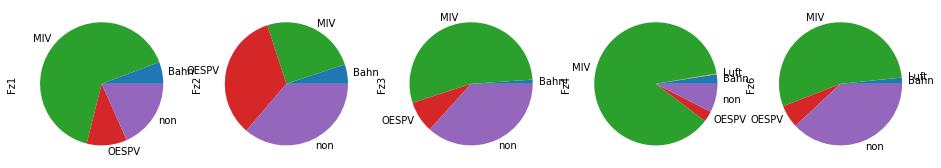

In [38]:
# Total traffic volumes by trip purpose
if manual:
    vp_norm.T.sum(axis=1).unstack('segment').plot.pie(
        subplots=True, figsize=(16, 4), legend=False)

In [39]:
# Restrict to inter-cell traffic and cells of the model
vp_norm.reset_index(level=['origin', 'destination'], inplace=True)
vp_norm = vp_norm.loc[(vp_norm['origin']!=vp_norm['destination']) &
                      (vp_norm['origin'].notna()) &
                      (vp_norm['destination'].notna())]
vp_norm.set_index(['origin', 'destination'], drop=True, inplace=True)

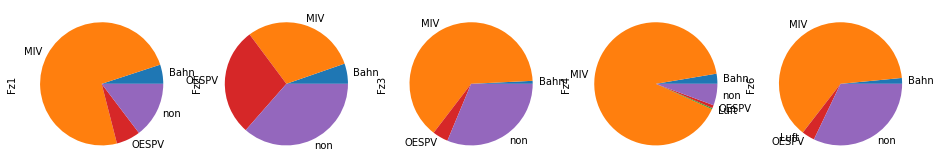

In [40]:
# Inter-zonal travel volumes
if manual:
    vp_norm.T.sum(axis=1).unstack('segment').plot.pie(
        subplots=True, figsize=(16, 4), legend=False)

In [40]:
# Clear the RAM if notebook stays open
vp2010 = None
vp2030 = None